In [1]:
import tensorflow as tf
import numpy as np
import joblib
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.__version__)

Num GPUs: 1
2.8.0


Load the resnet model from keras

In [3]:
resnet_50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-03 18:24:05.146647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 18:24:05.146772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

We already have the existing preprocessed and augmented dataset from the previous notebook.

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'])

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, classes=['covid', 'normal'], shuffle=False)

Found 1004 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


Currently the trainable parameters are: 23,534,592 which is not required for our current task.

In [6]:
resnet_50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We can see that the model is a Functional API model.

In [7]:
type(resnet_50_model)

keras.engine.functional.Functional

We flatten the input to the model and then pass it to the output layer, which is a new Dense Layer with a two neurons. The output layer is the final layer of the model.

In [8]:
# Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet_50_model.output)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(2, activation='sigmoid', name="AddedDense1")(flattened)

model = tf.keras.models.Model(inputs=resnet_50_model.input, outputs=fc2)

Apart from the 'AddedDense1' Layer that we created, all the rest of the layers are frozen.

In [9]:
for layer in model.layers:
    if layer.name == 'AddedDense1':
        break
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Model is saved in the covid_model_resnet.h5 file and the history is saved in the covid_history_resnet.pkl file.

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

if os.path.isfile('models/covid_model_resnet.h5'):
    model = load_model('models/covid_model_resnet.h5')
    history = joblib.load('models/history/covid_history_resnet.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2, callbacks=[callback])
    joblib.dump(history, 'models/history/covid_history_resnet.pkl')
    
    model.save('models/covid_model_resnet.h5')

# Tracking Convergence

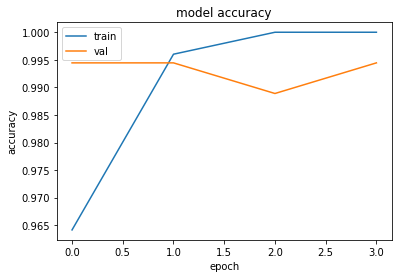

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

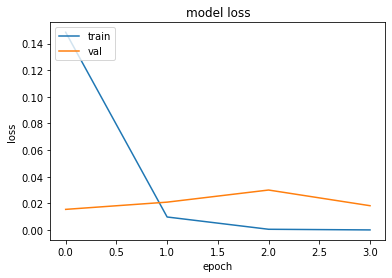

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

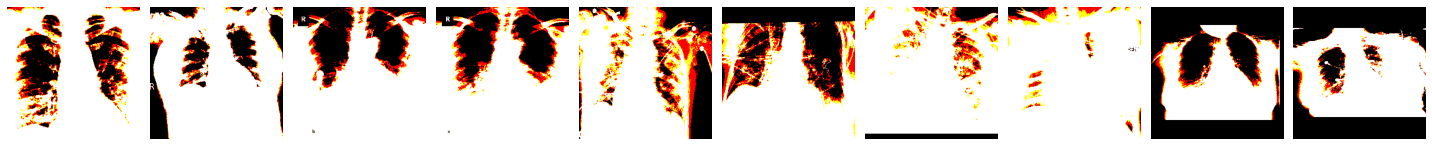

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

2022-05-03 18:24:51.643142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 18:24:51.894148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'covid': 0, 'normal': 1}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.99444444 0.00555556]
 [0.01111111 0.98888889]]


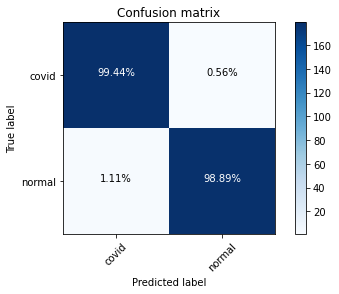

In [23]:
cm_plot_labels = ['covid', 'normal']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize=True)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(test_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))